Some description here in the future! <font color = 'red'> **Still heavily under construction** </font>

In [176]:
import boto3
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

Let's connect to S3 and grab the bucket that contains our data: 

In [4]:
s3 = boto3.client('s3')
bucket = 'personproject.b'

In [62]:
csv_obj = s3.get_object(Bucket=bucket, Key='cahsee2015.txt')
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')
df = pd.read_csv(StringIO(csv_string), sep = "\t", dtype={"MathTestDate": object, "ELATestDate": object, 
                                                          "ELAPercentNotPassed": float, "GradeLevel": object})

In [183]:
cahsee_15 = df

Record Type: Classifies the level of data 
04=state, 05=county,06=district,07=school

SummaryType: Subgroup

I know I do not want to work with all the data, so I'll examine the columns and pick which ones I'm interested in working with.

In [79]:
cahsee_15.columns.values

array(['CountyCode', 'DistrictCode', 'CharterNumber', 'SchoolCode',
       'CountyName', 'DistrictName', 'SchoolName', 'RecordType',
       'SummaryType', 'Administration', 'MathTestDate',
       'MathGrade10AnswerSheetsProcessed', 'MathNumberTested',
       'MathNumberPassed', 'MathPercentPassed', 'MathNumberNotPassed',
       'MathPercentageNotPassed', 'MathMEanScaleScore',
       'MathPSPercentCorrect', 'MathNSPercentCorrect',
       'MathAFPercentCorrect', 'MathMGPercentCorrect',
       'MathA1PercentCorrect', 'ELATestDate',
       'ELAGrade10AnswerSheetsProcessed', 'ELANumberTested',
       'ELANumberPassed', 'ELAPercentPassed', 'ELANumberNotPassed',
       'ELAPercentNotPassed', 'ELAMeanScaleScore', 'ELAWAPercentCorrect',
       'ELARCPercentCorrect', 'ELALRAPercentCorrect',
       'ELAWSPercentCorrect', 'ELAWCPercentCorrect', 'ELAES1AvgScore',
       'Filler', 'SystemDate', 'GradeLevel', 'MathPercentProfAndAbove',
       'ELAPercentProfAndAbove', 'Unnamed: 42'], dtype=object)

In [80]:
cahsee_15.head(3)

,CountyCode,DistrictCode,CharterNumber,SchoolCode,CountyName,DistrictName,SchoolName,RecordType,SummaryType,Administration,...,ELALRAPercentCorrect,ELAWSPercentCorrect,ELAWCPercentCorrect,ELAES1AvgScore,Filler,SystemDate,GradeLevel,MathPercentProfAndAbove,ELAPercentProfAndAbove,Unnamed: 42
0,1,0,0,0,Alameda County,,,5,1,S,...,53.0,43.0,55.0,2.0,0,07/28/15,12,0.0,0.0,NaN
1,1,0,0,0,Alameda County,,,5,7,S,...,53.0,43.0,55.0,2.0,0,07/28/15,12,0.0,0.0,NaN
2,1,0,0,0,Alameda County,,,5,8,S,...,52.0,43.0,56.0,2.1,0,07/28/15,12,0.0,0.0,NaN


In [184]:
cahsee_15 = cahsee_15[['CountyCode', 'DistrictCode', 'SchoolCode','CountyName','DistrictName', 'SchoolName', 'RecordType', 'SummaryType', 
    'MathGrade10AnswerSheetsProcessed','MathNumberTested', 'MathPercentPassed', 'MathPercentProfAndAbove', 
       'ELAGrade10AnswerSheetsProcessed', 'ELANumberTested', 'ELAPercentPassed', 'ELAPercentProfAndAbove']]

In [185]:
data_levels = {4: "state", 5: "county", 6: 'district', 7:'school'}

cahsee_15 = cahsee_15.replace({"RecordType": data_levels})

cahsee_15.head(5)

,CountyCode,DistrictCode,SchoolCode,CountyName,DistrictName,SchoolName,RecordType,SummaryType,MathGrade10AnswerSheetsProcessed,MathNumberTested,MathPercentPassed,MathPercentProfAndAbove,ELAGrade10AnswerSheetsProcessed,ELANumberTested,ELAPercentPassed,ELAPercentProfAndAbove
0,1,0,0,Alameda County,,,county,1,0,188,18.0,0.0,0,227,22.0,0.0
1,1,0,0,Alameda County,,,county,7,0,87,16.0,0.0,0,124,24.0,0.0
2,1,0,0,Alameda County,,,county,8,0,101,19.0,0.0,0,103,20.0,0.0
3,1,0,0,Alameda County,,,county,10,0,1,0.0,0.0,0,1,0.0,0.0
4,1,0,0,Alameda County,,,county,11,0,17,29.0,0.0,0,49,14.0,0.0


I'm noticing the Percent Prof and Above columns are showing 0% for the first few rows. This appears odd to me as the 'Percent Passed' columns have non-zero values. I want to explore this further after routine data cleaning.

While the report uses dashes to represent suppressed data for number tested (n) <= 10, the file represents supressed data as 0's in the data rows. We'll manually suppress these rows and check the distribution of scores for the test levels.

In [186]:
cahsee_15.loc[cahsee_15.MathNumberTested <= 10, ['MathPercentProfAndAbove','MathPercentPassed']] = np.nan 
cahsee_15.loc[cahsee_15.ELANumberTested <= 10, ['ELAPercentProfAndAbove','ELAPercentPassed']] = np.nan 

In [187]:
state_level = cahsee_15.loc[cahsee_15['RecordType'] == 'state','MathPercentPassed']
county_level = cahsee_15.loc[cahsee_15['RecordType'] == 'county','MathPercentPassed']
district_level = cahsee_15.loc[cahsee_15['RecordType'] == 'district','MathPercentPassed']
school_level = cahsee_15.loc[cahsee_15['RecordType'] == 'school','MathPercentPassed']

ValueError: max must be larger than min in range parameter.

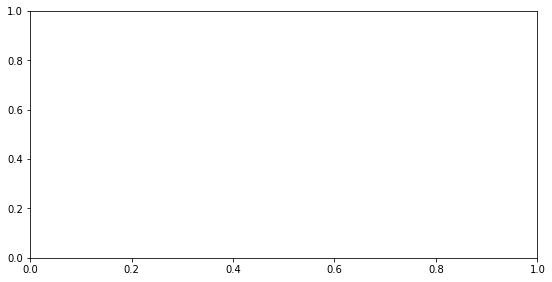

In [188]:
#TODO: Remove NaN for plotting

fig = plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.hist(state_level)
plt.subplot(222)
plt.hist(county_level)
plt.subplot(223)
plt.hist(district_level)
plt.subplot(224)
plt.hist(school_level)


In [118]:
test = cahsee_15.loc[cahsee_15['MathPercentPassed'] == 0.0, 'MathGrade10AnswerSheetsProcessed']

"In addition to the use of the CAHSEE as a graduation requirement, the CAHSEE
grade ten census administration is used in calculating the Academic Performance
Index for state accountability purposes and Adequate Yearly Progress (AYP) to
meet federal requirements."

In [130]:
cahsee_15 = (cahsee_15.query('MathGrade10AnswerSheetsProcessed > 0 & ELAGrade10AnswerSheetsProcessed > 0'))

In [142]:
state_level = cahsee_15.loc[cahsee_15['RecordType'] == 'state','MathPercentPassed']
county_level = cahsee_15.loc[cahsee_15['RecordType'] == 'county','MathPercentPassed']
district_level = cahsee_15.loc[cahsee_15['RecordType'] == 'district','MathPercentPassed']
school_level = cahsee_15.loc[cahsee_15['RecordType'] == 'school','MathPercentPassed']

(array([185274.,   3847.,   5752.,   5316.,   4688.,   4747.,   5493.,
         10007.,  17669.,  27763.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

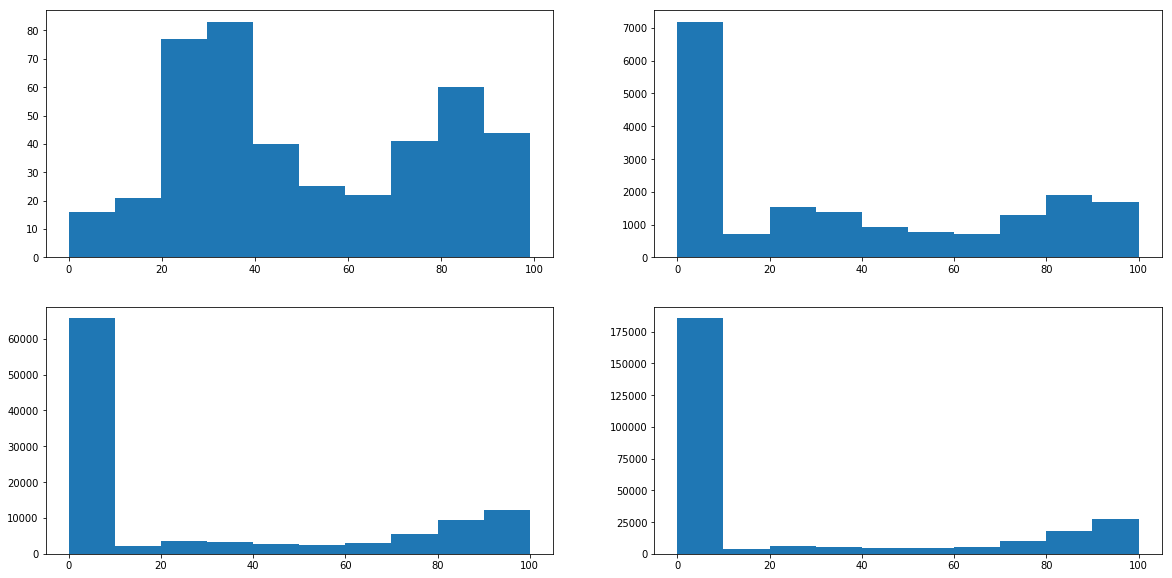

In [175]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.hist(state_level)
plt.subplot(222)
plt.hist(county_level)
plt.subplot(223)
plt.hist(district_level)
plt.subplot(224)
plt.hist(school_level)
